# Subsetting a watershed using Raven and Flyingpigeon

Here we use the processes from two PAVICS/Birdhouse services to perform an analysis based on an upstream watershed delineation

In [1]:
# Import the necessary libraries to format, send, and parse our returned results

%matplotlib inline

import birdy
import json
import xarray as xr
import requests
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd


print(
    'birdy:', birdy.__version__, '\n'
    'json:', json.__version__, '\n'
    'xarray:', xr.__version__, '\n'
    'requests:', requests.__version__, '\n'
    'matplotlib:', matplotlib.__version__, '\n'
    'geopandas:', gpd.__version__
)

birdy: 0.6.2 
json: 2.0.9 
xarray: 0.12.1 
requests: 2.21.0 
matplotlib: 3.0.2 
geopandas: 0.4.0


Assuming that you are running the Raven and FlyingPigeon modules locally, the default ports that the WPS services are mapped to are as follows:

* **Raven: http://localhost:9099/wps**
* **Flyingpigeon: http://localhost:8093/wps**


In [3]:
url_raven = "http://localhost:9099/wps"
url_flyingpigeon = "http://localhost:8093/wps"

raven = birdy.WPSClient(url_raven, progress=True)
fp = birdy.WPSClient(url_flyingpigeon, progress=True)

Let's consider trying to identify a sub-basin and all the upstream basins that flow into Lac Mistassini (Rupert Watershed) of Northern Quebec. Lac Mistassini is roughly found at 51.0 North, 73.621 West.

We'll start by launching a process with Raven to find the upstream watersheds and return us both a GeoJSON of this watershed as well as the feature IDs of all the sub-basins.

In [4]:
basin_process = raven.hydrobasins_select(
    location="-73.621, 51.000", aggregate_upstream=True)

# Wait for the process to complete before continuing with calculations

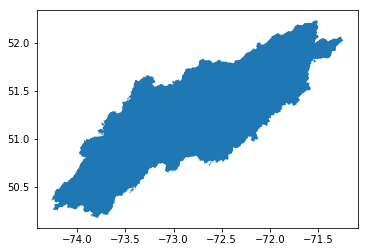

In [5]:
# Collecting the response

url = basin_process.get(asobj=False)

feature = requests.get(url[0]).content
upstream_ids = json.loads(requests.get(url[1]).content)

# Write our feature to a GeoJSON
file_name = "mistassini.geojson"
with open(file_name, "wb") as f:
    f.write(feature)

# Plot our vector shapefile
df = gpd.read_file(file_name)
df.plot()

In [6]:
# Verify that the HydroBASINS IDs are present in the response

for basin in upstream_ids:
    print(basin)

USGS_HydroBASINS_lake_na_lev12.67061
USGS_HydroBASINS_lake_na_lev12.67088
USGS_HydroBASINS_lake_na_lev12.67089
USGS_HydroBASINS_lake_na_lev12.67090
USGS_HydroBASINS_lake_na_lev12.67091
USGS_HydroBASINS_lake_na_lev12.67097
USGS_HydroBASINS_lake_na_lev12.67098
USGS_HydroBASINS_lake_na_lev12.67099
USGS_HydroBASINS_lake_na_lev12.67100
USGS_HydroBASINS_lake_na_lev12.67101
USGS_HydroBASINS_lake_na_lev12.67102
USGS_HydroBASINS_lake_na_lev12.67103
USGS_HydroBASINS_lake_na_lev12.67104
USGS_HydroBASINS_lake_na_lev12.67105
USGS_HydroBASINS_lake_na_lev12.67106
USGS_HydroBASINS_lake_na_lev12.67107
USGS_HydroBASINS_lake_na_lev12.67108
USGS_HydroBASINS_lake_na_lev12.67116
USGS_HydroBASINS_lake_na_lev12.67117
USGS_HydroBASINS_lake_na_lev12.67118
USGS_HydroBASINS_lake_na_lev12.67119
USGS_HydroBASINS_lake_na_lev12.67120
USGS_HydroBASINS_lake_na_lev12.67121
USGS_HydroBASINS_lake_na_lev12.67122
USGS_HydroBASINS_lake_na_lev12.67123
USGS_HydroBASINS_lake_na_lev12.67124
USGS_HydroBASINS_lake_na_lev12.67132
U

These IDs are WFS addresses to the individual features from the vector data present on GeoServer. So long as we know the address of the GeoServer, we can use these addresses to pull data from the data server and launch processes using a PAVICS/Birdhouse process that is located elsewhere.

In [7]:
# Address of the GeoServer where the HydroBASINS data is pulled from
geoserver = "https://boreas.ouranos.ca/geoserver/wfs"

# A local address of a NetCDF file
nc1 = "/home/tjs/Desktop/tas/tas_Amon_CanESM2_rcp85_r1i1p1_200601-210012.nc"

# The first sub-basin where our point was taken
primary_basin = upstream_ids[0]


x = fp.subset_wfs_polygon(
    resource=nc1,
    typename="public:USGS_HydroBASINS_lake_na_lev12", # The store and name of the data set 
    geoserver=geoserver, # The address of the GeoServer
    featureids=primary_basin, # The ID of the individual feature
    mosaic="False",
)

In [8]:
# Collect the file

file_url, meta = x.get(asobj=False)
response = requests.get(file_url).content
with open('mistassini.nc', 'wb') as f:
    f.write(response)

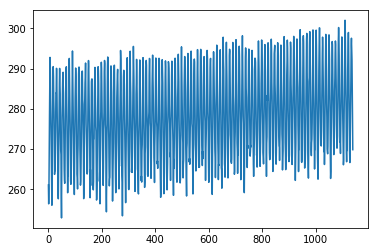

In [21]:
# Open with xarray and plot with matplotlib

ds = xr.open_dataset('mistassini.nc')
plt.plot(ds.tas)